- Ichwan Rizky Wahyudin (1301213434)
- Abdul Wasiul Khair (1301213278)

In [88]:
import glob
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from PIL import Image

In [89]:
dataset_dir = f"Datasets/"

In [90]:
def loadData(arr, labelobject, target_size=(256, 256)):
    label = []
    strr = f"Datasets/{labelobject}/*.jpg"
    for file in glob.glob(strr):
        img = Image.open(file)
        img = img.resize(target_size)
        img = np.asarray(img)
        arr.append(img)
        label.append(labelobject)
    return arr, label


In [91]:
cat=[]
dog=[]

cat,label_cat = loadData(cat,'cats')
dog,label_dog = loadData(dog,'dogs')

In [92]:
cat = np.array(cat)
dog = np.array(dog)

X = np.concatenate((cat,dog),axis=0)
y = np.concatenate((label_cat,label_dog),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [93]:
def preprocessing(arr, resize=False):
    arr_prep = []
    for i in range(len(arr)):
        img = arr[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if resize:
            img = cv2.resize(img, (64, 64))
        arr_prep.append(img)
    
    return arr_prep


In [94]:
x_train_prep = preprocessing(X_train, resize=True)
x_test_prep = preprocessing(X_test,resize=True)

### LBP

In [95]:
def extract_LBP(img):
    
    lbp = local_binary_pattern(img, 24,8, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, 27),range=(0, 26))                   
    hist = hist.astype("float")                         
    hist /= (hist.sum() + (1e-7))
    return hist

In [96]:
def feature_extraction_LBP(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(extract_LBP(arr[i]))
    return arr_feature

### Menampilkan hasil ekstraksi fitur LBP

In [126]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

def visualize_lbp_extraction(images):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(10, 5*len(images)))

    for idx, img in enumerate(images):
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

        lbp = local_binary_pattern(gray_img, 24, 8, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        hist = hist.astype("float")
        hist /= (hist.sum() + (1e-7))

        axes[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[idx, 0].set_title('Original Image')

        axes[idx, 1].bar(np.arange(0, 26), hist, color='blue', edgecolor='black')
        axes[idx, 1].set_title('LBP Histogram')
        axes[idx, 1].set_xlabel('Bin')
        axes[idx, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

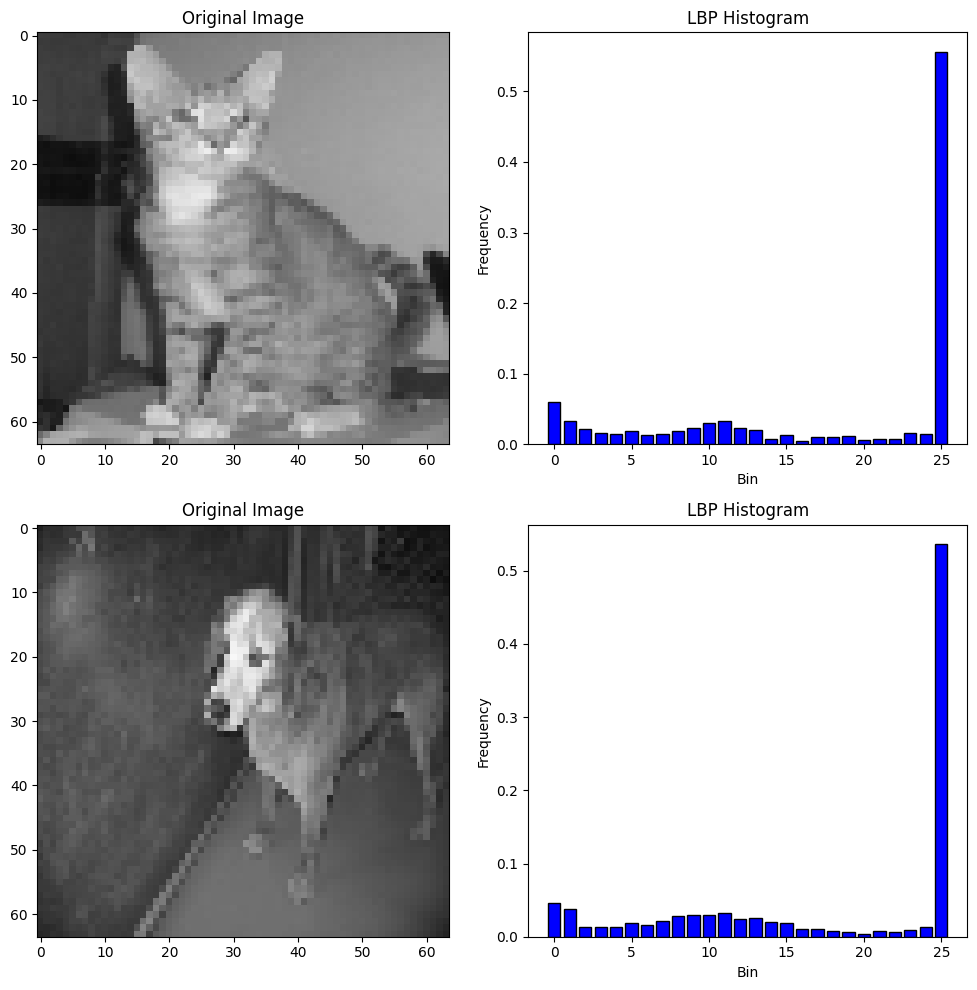

In [127]:
images = [x_train_prep[0], x_train_prep[1]]
visualize_lbp_extraction(images)

In [97]:
x_train_feature_LBP = np.array(feature_extraction_LBP(x_train_prep))
x_test_feature_LBP = np.array(feature_extraction_LBP(x_test_prep))

### HOG

In [98]:
def extract_hog(images):
    features = []
    for img in images:
        if img.ndim == 3 and img.shape[2] == 3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = img

        ftr, _ = hog(
            gray_img, 
            orientations=8, 
            pixels_per_cell=(10, 10),
            cells_per_block=(1, 1), 
            visualize=True
        )

        features.append(ftr)
    return np.array(features)

In [99]:
x_train_feature_HOG = extract_hog(x_train_prep)
x_test_feature_HOG = extract_hog(x_test_prep)

### Menampilkan hasil ekstraksi fitur HOG

In [124]:
def visualize_hog_extraction(images):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(10, 5*len(images)))

    for idx, img in enumerate(images):
        if img.ndim == 3 and img.shape[2] == 3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = img

        features, hog_image = hog(
            gray_img, 
            orientations=8, 
            pixels_per_cell=(10, 10),
            cells_per_block=(1, 1), 
            visualize=True
        )

        axes[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[idx, 0].set_title('Original Image')

        axes[idx, 1].imshow(hog_image, cmap='gray')
        axes[idx, 1].set_title('HOG Features')

    plt.tight_layout()
    plt.show()

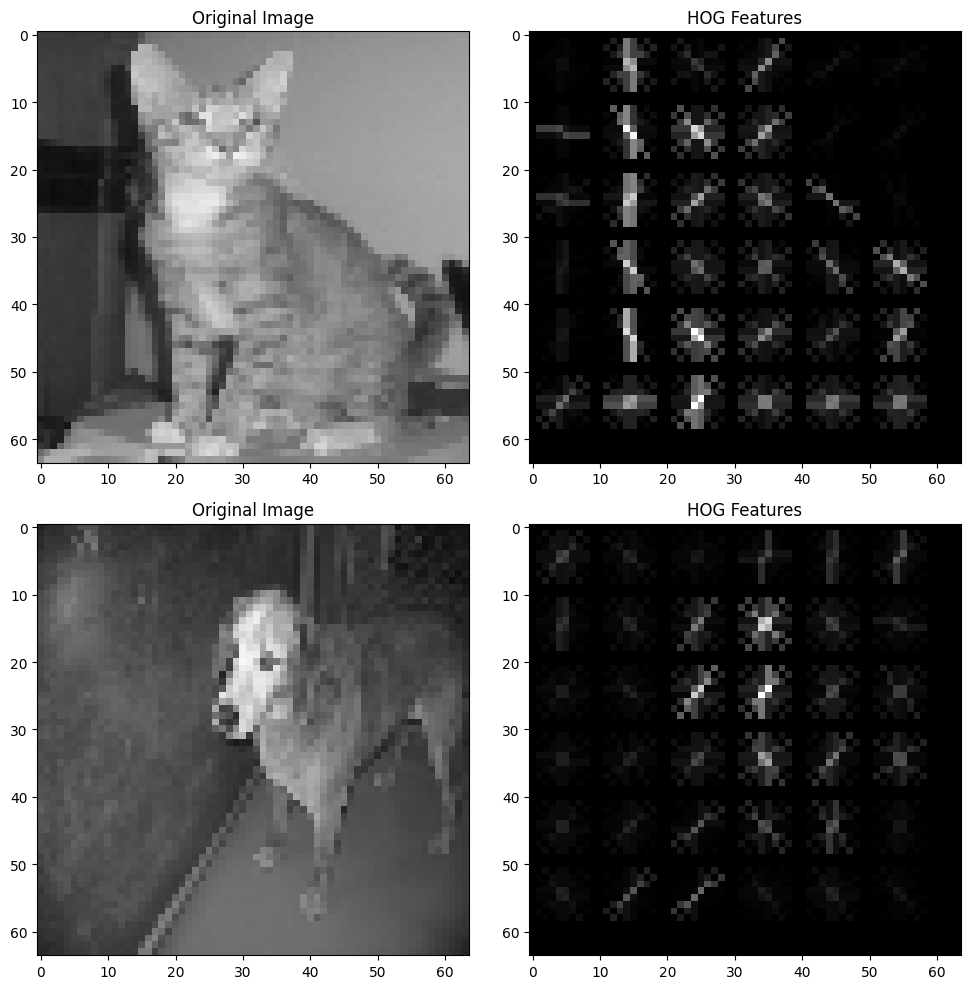

In [125]:
images = [x_train_prep[0], x_train_prep[1]]
visualize_hog_extraction(images)

### SIFT

In [100]:
from sklearn.cluster import MiniBatchKMeans
def extract_SIFT(images, n_clusters=100):
    sift = cv2.SIFT_create()
    sift_features = []

    for image in images:
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            sift_features.append(des)

    all_descriptors = np.concatenate(sift_features, axis=0)

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_descriptors)

    sift_histograms = []
    for features in sift_features:
        labels = kmeans.predict(features)
        histogram, _ = np.histogram(labels, bins=n_clusters)
        sift_histograms.append(histogram)

    return np.array(sift_histograms)


def feature_extraction_SIFT(arr):
    arr_feature = []
    for i in range(arr.shape[0]):
        img = arr[i] 
        sift_features = extract_SIFT(img)
        arr_feature.append(sift_features)
    return np.array(arr_feature)

### Menampilkan hasil ekstraksi fitur SIFT

In [128]:
def visualize_sift_extraction(images):
    sift = cv2.SIFT_create()

    fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(8, 6*len(images)))

    for idx, img in enumerate(images):
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img 

        kp, des = sift.detectAndCompute(gray, None)

        img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

        axes[idx].imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f'Image {idx + 1} with SIFT keypoints')

    plt.tight_layout()
    plt.show()

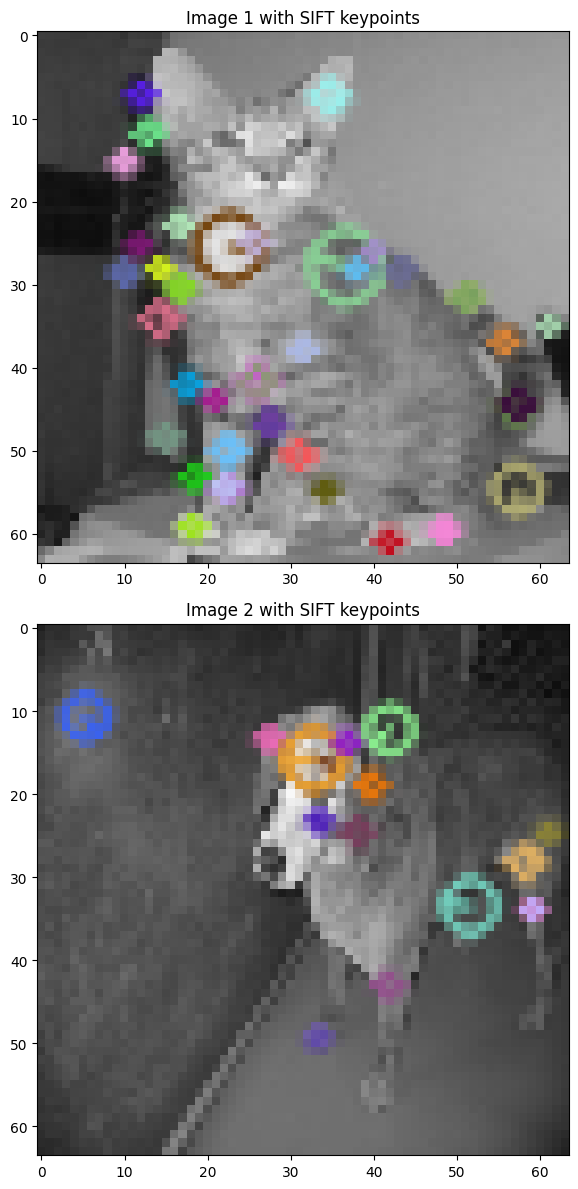

In [129]:
images = [x_train_prep[0], x_train_prep[1]]
visualize_sift_extraction(images)

In [101]:
x_train_feature_SIFT = extract_SIFT(x_train_prep)
x_test_feature_SIFT = extract_SIFT(x_test_prep)

c:\Users\abdul wasiul khair\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\abdul wasiul khair\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Evaluate LBP

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

rf = RandomForestClassifier()
grid_search_LBP = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_LBP.fit(x_train_feature_LBP, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_estimators': [10, 50, 100, 200, 300]},
             verbose=2)

In [103]:
print(grid_search_LBP.best_params_)

{'max_depth': 10, 'n_estimators': 100}


In [104]:
grid_predictions_LBP = grid_search_LBP.predict(x_test_feature_LBP)

              precision    recall  f1-score   support

        cats       0.59      0.66      0.62       403
        dogs       0.61      0.54      0.57       397

    accuracy                           0.60       800
   macro avg       0.60      0.60      0.60       800
weighted avg       0.60      0.60      0.60       800



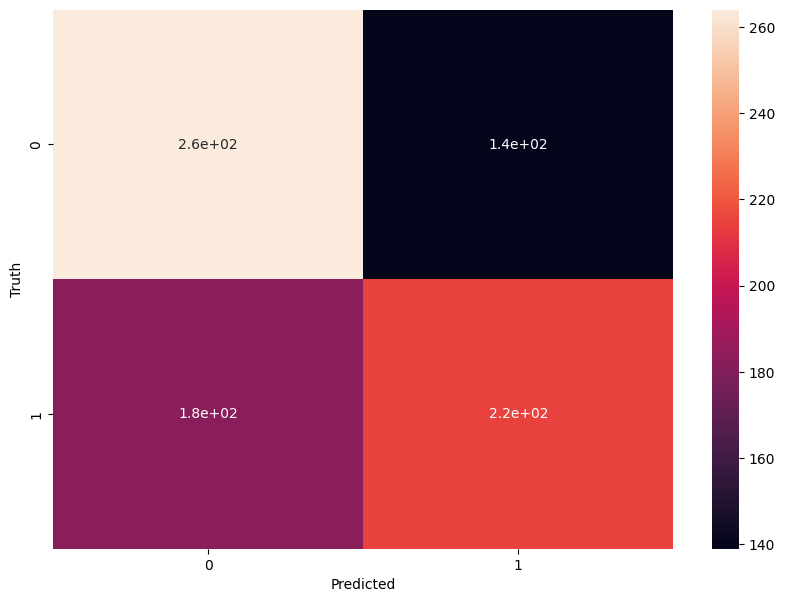

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, grid_predictions_LBP)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, grid_predictions_LBP))

### Evaluate HOG

In [106]:
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

rf = RandomForestClassifier()
grid_search_HOG = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_HOG.fit(x_train_feature_HOG, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_estimators': [10, 50, 100, 200, 300]},
             verbose=2)

In [107]:
print(grid_search_HOG.best_params_)

{'max_depth': 80, 'n_estimators': 200}


In [108]:
grid_predictions_HOG = grid_search_HOG.predict(x_test_feature_HOG)

              precision    recall  f1-score   support

        cats       0.67      0.75      0.71       403
        dogs       0.71      0.62      0.66       397

    accuracy                           0.69       800
   macro avg       0.69      0.69      0.69       800
weighted avg       0.69      0.69      0.69       800



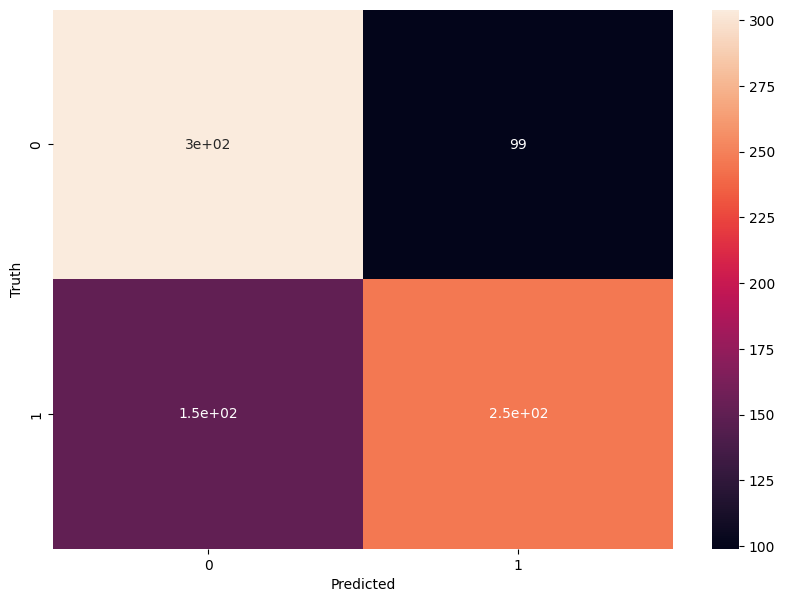

In [109]:
cm = confusion_matrix(y_test, grid_predictions_HOG)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, grid_predictions_HOG))

### Evaluasi SIFT

In [110]:
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

rf = RandomForestClassifier()
grid_search_SIFT = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_SIFT.fit(x_train_feature_SIFT, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_estimators': [10, 50, 100, 200, 300]},
             verbose=2)

In [111]:
print(grid_search_SIFT.best_params_)

{'max_depth': 90, 'n_estimators': 300}


In [112]:
grid_predictions_SIFT = grid_search_SIFT.predict(x_test_feature_SIFT)

              precision    recall  f1-score   support

        cats       0.53      0.46      0.49       403
        dogs       0.52      0.58      0.55       397

    accuracy                           0.52       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.52      0.52      0.52       800



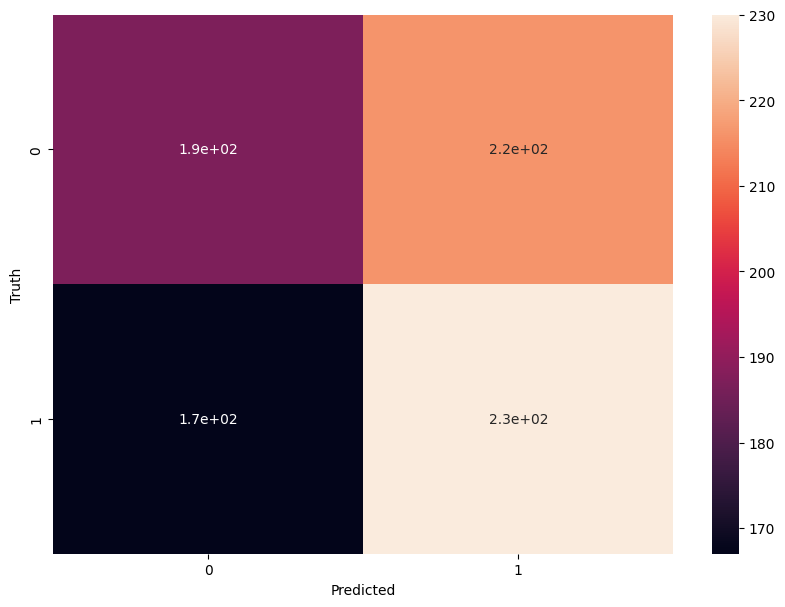

In [113]:
cm = confusion_matrix(y_test, grid_predictions_SIFT)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, grid_predictions_SIFT))

### Membandingkan Hasil dari ketiga ektraksi fitur yang telah dilakukan

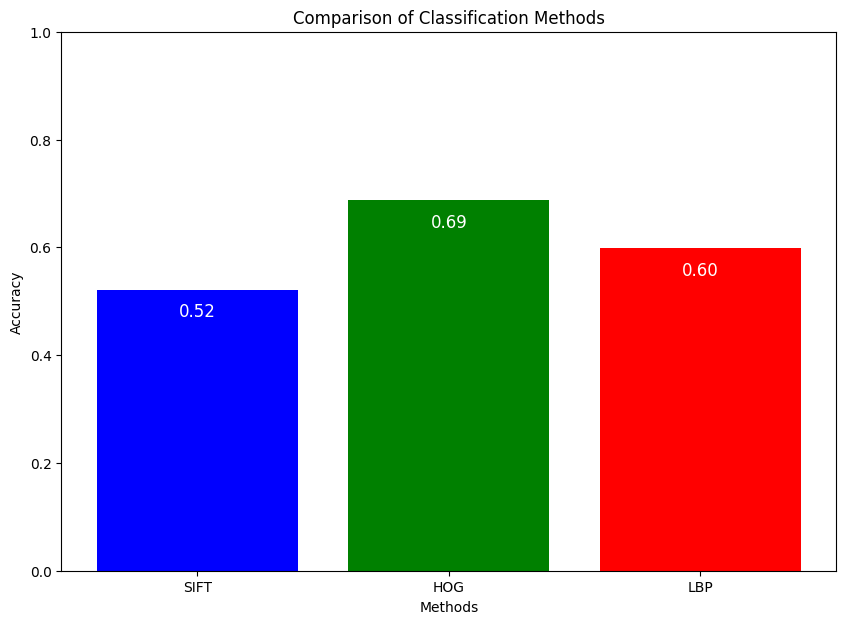

In [132]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

accuracy_SIFT = accuracy_score(y_test, grid_predictions_SIFT)
accuracy_HOG = accuracy_score(y_test, grid_predictions_HOG)
accuracy_LBP = accuracy_score(y_test, grid_predictions_LBP)

labels = ['SIFT', 'HOG', 'LBP']
accuracies = [accuracy_SIFT, accuracy_HOG, accuracy_LBP]

plt.figure(figsize=(10, 7))
bars = plt.bar(labels, accuracies, color=['blue', 'green', 'red'])

plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Comparison of Classification Methods')
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() - 0.05, 
             f'{acc:.2f}', 
             ha='center', 
             color='white', 
             fontsize=12)

plt.show()


Dengan melihat runtime dapat didapatkan hasil sebagai berikut:

Waktu yang diperlukan untuk Extraction feature:
- LBP = 6.7 detik
- HOG = 22 detik
- SIFT = 8.5 detik

Waktu yang dibutuhkan untuk training Random Forest Classifier:
- LBP = 17.2 detik
- HOG = 54.2 detik
- SIFT = 13.3 detik

### Kesimpulan
- Dapat dilihat Metode HOG untuk ekstraksi fitur memberikan hasil akurasi yang terbaik sebesar 0.69, namun HOG juga yang membutuhkan waktu paling lama, yaitu membutuhkan 22 detik untuk ekstraksi fitur, dan 54.2 detik untuk training Model dengan feature dari HOG.

- Dengan selisih akurasi 0.9, LBP mampu memberikan hasil akurasi sebesar 0.60 dengan membutuhkan waktu yang lebih sedikit dibandingkan dengan HOG. LBP membutuhkan 6.7 detik untuk ekstraksi fitur, dan 17.2 detik untuk training model dengan feature dari LBP.